<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/machine-learning-with-pytorch-and-scikit-learn/06-model-evaluation-and-hyperparameter-tuning/01_streamlining_ml_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Streamlining ML workflow

**Reference**

[Machine Learning with PyTorch and Scikit-Learn](https://github.com/rasbt/machine-learning-book)

##Setup

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as PathEffects

In [ ]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
  # setup marker generator and color map
  markers = ('o', 's', '^', 'v', '<')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # plot the decision surface
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
  lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  lab = lab.reshape(xx1.shape)
  plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  # plot class examples
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0], 
                y=X[y == cl, 1],
                alpha=0.8, 
                c=colors[idx],
                marker=markers[idx], 
                label=f'Class {cl}', 
                edgecolor='black')

##Unsupervised dimensionality reduction

### Extracting the principal components

In [ ]:
df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)

In [ ]:
df_wine.columns = [
    'Class label', 'Alcohol', 'Malic acid', 'Ash',
    'Alcalinity of ash', 'Magnesium', 'Total phenols',
    'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
    'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines', 'Proline'
]
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
# Splitting the data into 70% training and 30% test subsets.
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# standardize the features
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.transform(x_test)

In [ ]:
# Let's compute the covariance matrix
cov_matrix = np.cov(x_train_std.T)
# performe the eigendecomposition
eigen_vals, eigen_vecs = np.linalg.eig(cov_matrix)
print(f"Eigenvalues \n{eigen_vals}")

Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


###Total and explained variance

In [ ]:
# let's calculate the cumulative sum of explained variances
total = sum(eigen_vals)

var_exp = [(i / total) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

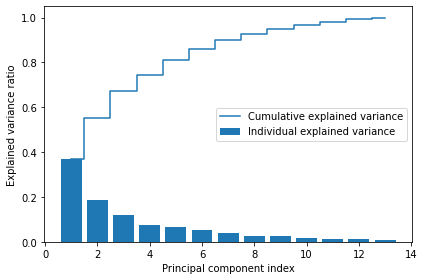

In [ ]:
plt.bar(range(1, 14), var_exp, align="center", label="Individual explained variance")
plt.step(range(1, 14), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

###Feature transformation

In [ ]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [ ]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(f"Matrix W: \n {w}")

Matrix W: 
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [ ]:
x_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [ ]:
x_train_pca = x_train_std.dot(w)

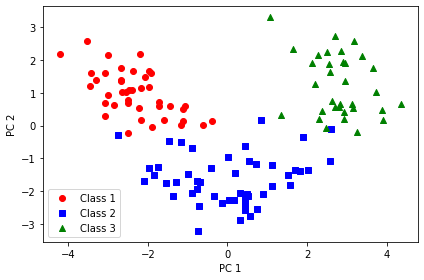

In [ ]:
# let’s visualize the transformed Wine training dataset
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
  plt.scatter(x_train_pca[y_train==l, 0], x_train_pca[y_train == l, 1], c=c, label=f"Class {l}", marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

###Principal component analysis

In [ ]:
# initializing the PCA transformer
pca = PCA()

# dimensionality reduction
x_train_pca = pca.fit_transform(x_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

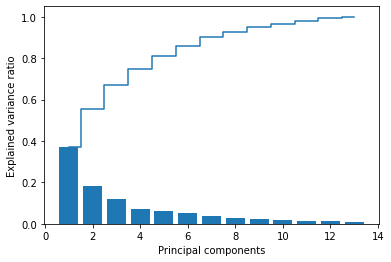

In [ ]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, align="center")
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where="mid")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.show()

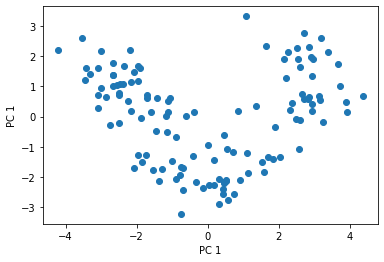

In [ ]:
# initializing the PCA transformer 
pca = PCA(n_components=2)

# dimensionality reduction
x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1])
plt.xlabel("PC 1")
plt.ylabel("PC 1")
plt.show()

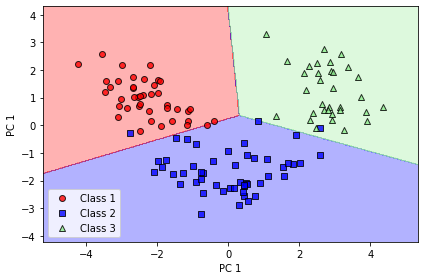

In [ ]:
# initializing the PCA transformer and logistic regression estimator
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=1)

# dimensionality reduction
x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

# fitting the logistic regression model on the reduced dataset
lr.fit(x_train_pca, y_train)
plot_decision_regions(x_train_pca, y_train, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 1")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

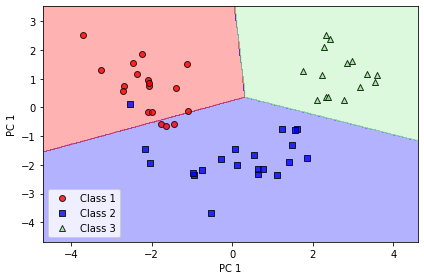

In [ ]:
# let’s plot the decision regions of the logistic regression on the transformed test dataset
plot_decision_regions(x_test_pca, y_test, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 1")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [ ]:
# let's keep all principal components by initializing the PCA class with the n_components parameter set to None 
pca = PCA(n_components=None)

x_train_pca = pca.fit_transform(x_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

###Assessing feature contributions

In [ ]:
# compute the 13×13-dimensional loadings matrix by multiplying the eigenvectors by the square root of the eigenvalues
loadings = eigen_vecs * np.sqrt(eigen_vals)

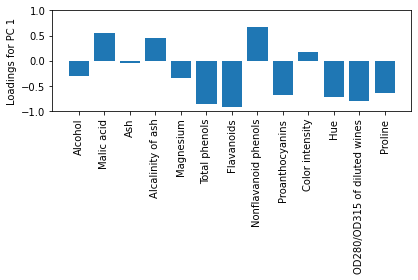

In [ ]:
# let us plot the loadings for the first principal component
fig, ax = plt.subplots()

ax.bar(range(13), loadings[:, 0], align="center")
ax.set_ylabel("Loadings for PC 1")
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

Note that a value of 1 describes a perfect positive correlation whereas a value of –1 corresponds to a
perfect negative correlation.

In [ ]:
loadings[:, 0]

array([-0.3020184 ,  0.54408942, -0.05600938,  0.45540829, -0.33970111,
       -0.8665386 , -0.9184327 ,  0.67279444, -0.67489496,  0.16623657,
       -0.71769524, -0.81117245, -0.65291742])

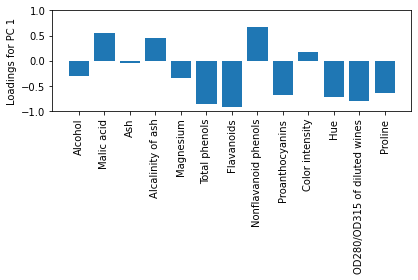

In [ ]:
# let's compute the factor loadings for our own PCA implementation
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# let us plot the loadings for the first principal component
fig, ax = plt.subplots()

ax.bar(range(13), sklearn_loadings[:, 0], align="center")
ax.set_ylabel("Loadings for PC 1")
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

In [ ]:
sklearn_loadings[:, 0]

array([-0.3020184 ,  0.54408942, -0.05600938,  0.45540829, -0.33970111,
       -0.8665386 , -0.9184327 ,  0.67279444, -0.67489496,  0.16623657,
       -0.71769524, -0.81117245, -0.65291742])

##Supervised data compression

###Computing the scatter matrices

In [ ]:
# Calculate the mean vectors for each class
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
  mean_vecs.append(np.mean(x_train_std[y_train == label], axis=0))
  print(f"MV {label}: {mean_vecs[label - 1]}\n")

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [ ]:
# Compute the within-class scatter matrix
d = 13  # number of features
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
  class_scatter = np.zeros((d, d))  # scatter matrix for each class
  for row in x_train_std[y_train == label]:
    row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
    class_scatter += (row - mv).dot((row - mv).T)
  S_W += class_scatter  # sum class scatter matrices

print(f"Within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}")

Within-class scatter matrix: 13x13


In [ ]:
# Better: covariance matrix since classes are not equally distributed
print(f"Class label distribution: {np.bincount(y_train)[1:]}")

Class label distribution: [41 50 33]


In [ ]:
d = 13  # number of features
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
  class_scatter = np.cov(x_train_std[y_train == label].T) 
  S_W += class_scatter  # sum class scatter matrices

print(f"Within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}")

Within-class scatter matrix: 13x13


In [ ]:
# Compute the between-class scatter matrix
mean_overall = np.mean(x_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)   # make column vector

d = 13  # number of features
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
  n = x_train_std[y_train == i + 1, :].shape[0]
  mean_vec = mean_vec.reshape(d, 1)  # make column vectors
  S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print(f"Between-class scatter matrix:: {S_B.shape[0]}x{S_B.shape[1]}")

Between-class scatter matrix:: 13x13


###Selecting linear discriminants for the new feature subspace